# Démonstration 4: K-PPV, ensembles d'entraînement et de test, surface de décision. 26/09

La semaine dernière vous avez implanté un 1-Plus-Proche-Voisin (1-PPV). Cette semaine vous implanterez un K-PPV. Par contre, cette semaine nous ferons aussi appel à la notion d'ensembles d'entrainement et de test, ainsi qu'à la notion de surface de décision. 


- Votre première étape est de vous remémorer le fonctionnement du K-PPV.
- Nous fournissons le cadre général où il vous faudra insérer le code de k-ppv. On y retrouve notamment des fonctions pour rendre certaines tâches (comme l'affichage des résultats) plus faciles. Cela vous permettra de vous concentrer sur la partie algorithmique de cette démonstration. Téléchargez et le notebook fourni.
- Exécutez toutes les cellures de code en cliquant dans le menu Cell/Run all: Vous observez à la dernière cellule le fonctionnement d'un classifieur qui fait une prédiction constante (c'est-à-dire qu'il prédit, pour chaque exemple, l'étiquette 1 (bleu)).
Familiarisez-vous avec le code des cinq sections suivantes:
    - **Fonctions utilitaires:** définit des fonctions utiles (visualisation, évaluation)
    - **Classe k-ppv:** c'est ici que vous devez implanter le classifieur.
    - **Chargement et division des données:** charge un jeu de données et le divise en deux parties (train, test)
    - **Initialisation et entraînement du classifieur:** entraîne un modèle k-PPV sur les données d'entraînement et obtient les prédictions des étiquettes pour les données de test
    - **Matrice de confusion et surface de décision:** Affiche la matrice de confusion et visualise la surface de décision

**Votre objectif pour la séance** est de comprendre le fonctionnement général du code fourni puis de compléter la fonctionkppv.compute_predictions().



### Classes en python

Pour cette démo, nous implémenterons k-ppv à l'intérieure d'une **classe**. Vous pouvez lire ce [tutoriel](http://docs.python.org/2/tutorial/classes.html) si vous n'êtes pas à l'aise avec les classes en python. La classe `kppv` est déjà partiellement implémenté à la section **Classe k-ppv**, il ne vous reste qu'à compléter la méthode `compute_predictions`

## Fonctions utilitaires

Vous n'avez rien à implémenter ici. Lisez simplement le code et familiarisez vous avez. Il sera possible de tester les fonctions `teste` et tout particulièrement `gridplot` à la fin du notebook.

In [1]:
%pylab inline
import numpy as np
import random
import pylab
import time

Populating the interactive namespace from numpy and matplotlib


Cette fonction calcule la distance Minkowski entre un vecteur x et une matrice Y. Ça vous rappelle quelque chose?

In [2]:
def minkowski_mat(x,Y,p=2):
    return (np.sum((np.abs(x-Y))**p,axis=1))**(1.0/p)

La fonction `conf_matrix` prend en entrée:

 - `etiquettesTest` - les étiquettes de test
 - `etiquettesPred` - les étiquettes prédites
et retourne une table présentant les résultats

Voir la définition d'une [matrice de confusion](http://fr.wikipedia.org/wiki/Matrice_de_confusion).

In [3]:
def conf_matrix(etiquettesTest, etiquettesPred):

	n_classes = max(etiquettesTest)
	matrix = np.zeros((n_classes,n_classes))

	for (test,pred) in zip(etiquettesTest, etiquettesPred):
		matrix[test-1,pred-1] += 1

	return matrix

La fonction `gridplot` prend en entrée:

 - `classifieur` - un classifieur tel que `kppv`
 - `train` - un ensemble d'entraînement
 - `test` - un ensemble de test
 - `n_points` - la taille de la grille pour afficher la surface de décision (x,x)

Dépendamment de la puissance de calcul de votre ordinateur, le calcul des prédictions sur la grille peut être lent. Il est préférable de faire vos premiers tests avec une grille moins fine, disons de 25 par 25. Vous pourrez ensuite augmenter la valeur à 50 ou même 100 pour obtenir de plus beaux graphiques.

In [4]:
# fonction plot
def gridplot(classifieur,train,test,n_points=50):

    train_test = np.vstack((train,test))
    (min_x1,max_x1) = (min(train_test[:,0]),max(train_test[:,0]))
    (min_x2,max_x2) = (min(train_test[:,1]),max(train_test[:,1]))

    xgrid = np.linspace(min_x1,max_x1,num=n_points)
    ygrid = np.linspace(min_x2,max_x2,num=n_points)

	# calcule le produit cartesien entre deux listes
    # et met les resultats dans un array
    thegrid = np.array(combine(xgrid,ygrid))

    les_comptes = classifieur.compute_predictions(thegrid)
    classesPred = np.argmax(les_comptes,axis=1)+1

    # La grille
    # Pour que la grille soit plus jolie
    #props = dict( alpha=0.3, edgecolors='none' )
    #pylab.scatter(thegrid[:,0],thegrid[:,1],c = classesPred, s=50, edgecolors='none', alpha=0.1)
    pylab.pcolormesh(xgrid, ygrid, classesPred.reshape((n_points, n_points)).T, alpha=.3)
	# Les points d'entrainment
    pylab.scatter(train[:,0], train[:,1], c = train[:,-1], marker = 'v', s=150)
    # Les points de test
    pylab.scatter(test[:,0], test[:,1], c = test[:,-1], marker = 's', s=150)

    ## Un petit hack, parce que la fonctionalite manque a pylab...
    h1, = pylab.plot([min_x1], [min_x2], marker='o', c = 'w',ms=5) 
    h2, = pylab.plot([min_x1], [min_x2], marker='v', c = 'w',ms=5) 
    h3, = pylab.plot([min_x1], [min_x2], marker='s', c = 'w',ms=5) 
    handles = [h1,h2,h3]
    ## fin du hack

    labels = ['grille','train','test']
    pylab.legend(handles,labels)

    pylab.axis('equal')
    pylab.show()
    
## http://code.activestate.com/recipes/302478/
def combine(*seqin):
    '''returns a list of all combinations of argument sequences.
for example: combine((1,2),(3,4)) returns
[[1, 3], [1, 4], [2, 3], [2, 4]]'''
    def rloop(seqin,listout,comb):
        '''recursive looping function'''
        if seqin:                       # any more sequences to process?
            for item in seqin[0]:
                newcomb=comb+[item]     # add next item to current comb
                # call rloop w/ rem seqs, newcomb
                rloop(seqin[1:],listout,newcomb)
        else:                           # processing last sequence
            listout.append(comb)        # comb finished, add to list
    listout=[]                      # listout initialization
    rloop(seqin,listout,[])         # start recursive process
    return listout

matplotlib.__version__

'1.5.3'

## Classe k-ppv

La classe `kppv` prend en paramètre:

 - `n_classes` - le nombre de classe du problème
 - `dist_func` - une fonction pour calculer la distance des points
 - `n_voisins` - le nombre de voisin à visiter 

La méthode `train` n'est en fait que le stockage de l'ensemble d'entraînement. Tout le travail du modèle $k$-ppv s'éffectue lors de la prédiction. 

La méthode `compute_predictions` prend en entré une matrice de données de test (sans étiquettes) et retourne une matrice des comptes pour chaque exemple de test. Cette matrice est donc de dimensions (n_exemple,n_classes).

Vous devrez pour chaque point de l'ensemble de test :

 - **calculer les distances** à tous les points de l'ensemble d'entraînement (en utilisant dist_func)
 - parcourir les distances pour **trouver les $k$ voisins** du point de test courant
 - **dénombrer les voisins** correspondant à chaque classe et les sauvegarder dans les_comptes

**Note :** La sortie de la méthode `kppv.compute_predictions()` doit être assez générale pour qu'on puisse l'utiliser dans plusieurs contextes. C'est pour cela qu'on vous demande que la fonction retourne une matrice qui contient des comptes pour chaque exemple de test et non pas les classes prédites pour chaque exemple de test.

In [5]:
class kppv:
    def __init__(self,n_classes, dist_func=minkowski_mat, n_voisins=1):
        self.n_classes = n_classes
        self.dist_func = dist_func
        self.n_voisins = n_voisins

    # La fonction d'entrainement d'un k-PPV est juste le stockage de l'ensemble d'entrainement
    def train(self, train_inputs, train_labels):
        self.train_inputs = train_inputs
        self.train_labels = train_labels

    ###
    # La fonction de prédiction prend en entrée:
    #   test_data - les données de test (sans l'étiquette)
    # et retourne une matrice des comptes pour chaque exemple de test. 
    # Chaque rangée de cette matrice contient, pour chaque classe, le nombre 
    # de voisins appartenant à cette classe. 
    ###
    def compute_predictions(self, test_data):
        # Initialisation de la matrice à retourner
        num_test = test_data.shape[0]
        les_comptes = np.ones((num_test,self.n_classes))

        # Pour chaque point de test
        for (i,ex) in enumerate(test_data):
            # i est l'indice de la rangée
            # ex est la i'eme rangée

            # trouve les distances à tous les pointsd'entrainement
            distances = self.dist_func(ex,self.train_inputs)
            # garde l'index des k plus proches voisins
            ind_voisins = np.argsort(distances)[:self.n_voisins]
            # liste des k plus proches voisins
            cl_voisins = list(self.train_labels[ind_voisins]-1)
            
            # Dénombre les voisins correspondant à chaque classe les mets dans les_comptes[i,:]
            # on prend le min de k et data.shape[0] pour permettre un k plus grand que le nombre d'exemples
            for j in range(min(self.n_voisins,self.train_inputs.shape[0])):
                cl_voisins[j]
                les_comptes[i]
                les_comptes[i,cl_voisins[j]] += 1

        return les_comptes

## Chargement et division des données

L'ensemble de donnée `iris` est divisé en deux parties, une pour l'entraînement et l'autre pour éffectuer des tests. Il est important de mélanger aléatoirement l'ensemble de données avant d'éffectuer la division. Pouvez vous dire pourquoi? 

Seulement deux colonnes des données sont utilisées afin de pouvoir les visualiser en deux dimensions.

In [6]:
# charger iris
iris = np.loadtxt('iris.txt')
data = iris

# Nombre de classes
n_classes = 3

# Nombre de points d'entrainement
n_train = 100

# Les colonnes (traits/caracteristiques) sur lesqueles on va entrainer notre modele
# Pour que gridplot fonctionne, len(train_cols) devrait etre 2
train_cols = [0,1]
# L'indice de la colonne contenant les etiquettes
target_ind = [data.shape[1] - 1]

# Commenter pour avoir des resultats non-deterministes 
random.seed(3395)
# Determiner au hasard des indices pour les exemples d'entrainement et de test
inds = range(data.shape[0])
random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]

# Separer les donnees dans les deux ensembles
train_set = data[train_inds,:]
train_set = train_set[:,train_cols + target_ind]
test_set = data[test_inds,:]
test_set = test_set[:,train_cols + target_ind]

# Separarer l'ensemble de train et test dans les entrees et les etiquettes
train_inputs = train_set[:, :-1]
train_labels = train_set[:, -1].astype('int32')
test_inputs = test_set[:,:-1]
test_labels = test_set[:,-1].astype('int32')

## Initialisation et entraînement du classifieur

On prends ici la argmax des prédictions pour avoir la classe majoritaire pour chaque exemple du test. 

N'oubliez pas de réexécuter cette cellule si vous avez modifié votre modèle et voulez afficher la surface de décision à la section suivante. 

In [7]:
# Nombre de voisins (k) dans k-PPV
k = 10
print "On va entrainer un ",k, "-PPV sur ", n_train, " exemples d'entrainement"

# Créer le classifieur
model = kppv(n_classes,dist_func = minkowski_mat, n_voisins = k)
# L'entrainer
model.train(train_inputs, train_labels)
# Obtenir ses predictions
t1 = time.clock()
les_comptes = model.compute_predictions(test_inputs)
t2 = time.clock()
print 'Ca nous a pris ', t2-t1, ' secondes pour calculer les predictions sur ', test_inputs.shape[0],' points de test'

# Vote majoritaire (+1 puisque nos classes sont de 1 a n)
classes_pred = np.argmax(les_comptes,axis=1)+1

On va entrainer un  10 -PPV sur  100  exemples d'entrainement
Ca nous a pris  0.003141  secondes pour calculer les predictions sur  50  points de test


## Matrice de confusion et surface de décision

On imprime ici la matrice de confusion, très utile pour comprendre quelles classes sont moins bien prédites par notre classifieur. On crée aussi un graphique qui affiche les points d'entraînement ainsi que ceux de test et la surface de décision de notre modèle. 

Avant de passer à la section suivante, assurez-vous que votre implémentation de $k$-ppv fonctionne bien en exécutant ce code. N'hésitez surtout pas à poser des questions si vous avez de la difficulté à interpréter la matrice de confusion et le graphique.

La matrice de confusion est:
[[ 14.   0.   0.]
 [  0.  13.   4.]
 [  0.   4.  15.]]
L'erreur de test est de  16.0 %


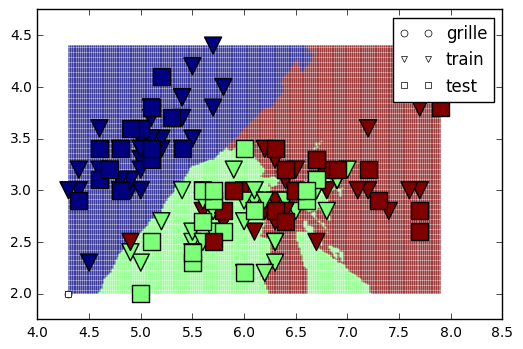

Ca nous a pris  2.219113  secondes pour calculer les predictions sur  40000  points de la grille
On va sauvegarder la figure dans  grille__k=10_c1=0_c2=1.png


In [8]:
# Faire les tests
# Matrice de confusion 
confmat = conf_matrix(test_labels, classes_pred)
print 'La matrice de confusion est:'
print confmat

# Erreur de test
sum_preds = np.sum(confmat)
sum_correct = np.sum(np.diag(confmat))
print "L'erreur de test est de ", 100*(1.0 - (float(sum_correct) / sum_preds)),"%"

# Taille de la grille = grid_size x grid_size
grid_size = 200

if len(train_cols) == 2:
    # Surface de decision
    t1 = time.clock()
    gridplot(model,train_set,test_set,n_points = grid_size)
    t2 = time.clock()
    print 'Ca nous a pris ', t2-t1, ' secondes pour calculer les predictions sur ', grid_size * grid_size, ' points de la grille'
    filename = 'grille_' + '_k=' + str(k) + '_c1=' + str(train_cols[0]) + '_c2=' + str(train_cols[1])+'.png'
    print 'On va sauvegarder la figure dans ', filename
    pylab.savefig(filename,format='png')
else:
    print 'Trop de dimensions (', len(train_cols),') pour pouvoir afficher la surface de decision'

## Expérimentations

Maintenant que tous fonctionne, il est temps de faire des expérimentations pour mieux comprendre l'importance de différents facteurs. Travaillez directement sur le code précédent pour effectuer ces tests. 

- Variez les tailles de `train_set` et `test_set` et observez l'impact sur l'erreur de test et la surface de décision


> À vous d'expérimenter avec le code précédent.

> Vous devriez voir que l'erreur sur l'ensemble de test augmente à mesure que l'ensemble d'entraînement est plus petite. On va toujours essayer
> d'avoir un ensemble d'entraînement le plus grand possible afin de s'approcher au maximum de la *distribution naturelle* des exemples. 

- Essayez $k=1,2,\dots,10$. 
  - Est-ce que l'erreur de test change? 
  - Est-ce qu'il existe un $k$ optimal? 
  - Est-ce qu'en regardant seulement la surface de décision vous êtes en mesure de dire quel $k$ est optimal?


> Encore une fois, à vous d'expérimenter avec le code précédent.

> L'erreur de test devrait changer d'un $k$ à l'autre. Avec le même *seed* que dans ce code, vous devriez trouver $k=7$ comme optimal. 
> Remarquez que la fluctuation de l'erreur de test est en dent de scie et de quelque % seulement pour des $k$ allant de 1 à 10 dans ce cas ci.
> Il est difficile de voir sur le graphique de la surface de décision
> quel $k$ est optimal. Cependant, la réduction de la capacité du modèle lorsque $k$ augmente est visible avec les frontières de 
> la surface de décision qui deviennent plus lisse. C'est-à-dire que plus $k$ est grand, moins la puissance de représentation du modèle est forte. Le cas extrème de $k=1$ est un exemple frappant où le modèle est capable d'apprendre par coeur tout les ensembles d'entraînement. Une grande capacité est importante pour pouvoir représenter des données complexes, mais elle vient avec le danger de pouvoir sur-apprendre l'ensemble d'entraînement et mal généraliser sur l'ensemble de test comme dans le cas $k=1$.

- Divisez l'ensemble d'entrainement en 3 parties: `train_set`, `valid_set` et `test_set` (de taille 100, 25 et 25, par exemple). Entrainez $k$-ppv sur `train_set`, choisissez la valeur optimale de `k` en testant sur `valid_set` et obtenez un estimé de l'erreur de généralisation en testant sur `test_set`. Cette fois-ci, utilisez tous les (quatre) traits/caractéristiques/features. D'après-vous, à quoi sert l'ensemble de validation?
  - Est-ce qu'il y a un écart entre l'erreur de validation et l'erreur de test pour le $k$ optimal trouvé avec l'ensemble de validation? Est-ce qu'il devrait y en avoir? (la réponse se trouve dans la question)

In [9]:
def experience(n_train=100,n_valid=25,train_cols=[0,1],ks=[1],seed=3395):

    # L'indice de la colonne contenant les etiquettes
    target_ind = [data.shape[1] - 1]

    # Commenter pour avoir des resultats non-deterministes 
    if seed:
        random.seed(seed)
    # Determiner au hasard des indices pour les exemples d'entrainement et de test
    inds = range(data.shape[0])
    random.shuffle(inds)
    assert n_train+n_valid < data.shape, "il ne reste aucun exemple pour l'ensemble de test"
    train_inds = inds[:n_train]
    valid_inds = inds[n_train:n_train+n_valid]
    test_inds = inds[n_train+n_valid:]

    # Separer les donnees dans les deux ensembles
    train_set = data[train_inds,:]
    train_set = train_set[:,train_cols + target_ind]
    valid_set = data[valid_inds,:]
    valid_set = valid_set[:,train_cols+target_ind]
    test_set = data[test_inds,:]
    test_set = test_set[:,train_cols + target_ind]
    
    # Separarer l'ensemble de test dans les entrees et les etiquettes
    train_inputs = train_set[:, :-1]
    train_labels = train_set[:, -1].astype('int32')
    valid_inputs = valid_set[:,:-1]
    valid_labels = valid_set[:,-1].astype('int32')
    test_inputs = test_set[:,:-1]
    test_labels = test_set[:,-1].astype('int32')
    
    best_result = float('inf')
    best_k = 0
    best_model = None
    for k in ks:
        # Créer le classifieur
        model = kppv(n_classes,dist_func = minkowski_mat, n_voisins = k)
        # L'entrainer
        model.train(train_inputs, train_labels)
        # Obtenir ses predictions
        les_comptes = model.compute_predictions(valid_inputs)

        # Vote majoritaire (+1 puisque nos classes sont de 1 a n)
        classes_pred = np.argmax(les_comptes,axis=1)+1
        
        result = (1.0-(valid_labels==classes_pred).mean())
        
        if result < best_result:
            best_model = model
            best_k = k
            best_result = result
    
    return train_set, valid_set, test_set, best_model, best_k
    
def graphiques(train_set, valid_set, test_set, model):

    valid_inputs = valid_set[:,:-1]
    test_inputs = test_set[:,:-1]
    valid_labels = valid_set[:,-1].astype('int32')
    test_labels = test_set[:,-1].astype('int32')
    
    les_comptes = model.compute_predictions(valid_inputs)
    valid_pred = np.argmax(les_comptes,axis=1)+1
    les_comptes = model.compute_predictions(test_inputs)
    test_pred = np.argmax(les_comptes,axis=1)+1    
    
    # Matrice de confusion
    confmat = conf_matrix(valid_labels, valid_pred)
    print "La matrice de confusion pour l'ensemble de validation est:"
    print confmat
    
    # Matrice de confusion
    confmat = conf_matrix(test_labels, test_pred)
    print "La matrice de confusion pour l'ensemble de test est:"
    print confmat

    # Erreur de validation
    print "L'erreur de validation est de ", 100.*(1.0 - (valid_labels==valid_pred)).mean(),"%"
    
    # Erreur de test
    print "L'erreur de test est de ", 100.*(1.0 - (test_labels==test_pred)).mean(),"%"

    # Taille de la grille = grid_size x grid_size
    grid_size = 200

    if len(train_cols) == 2:
        # Surface de decision
        gridplot(model,train_set,test_set,n_points = grid_size)
        print 'On va sauvegarder la figure dans ', filename
        pylab.savefig(filename,format='png')
    else:
        print 'Trop de dimensions (', len(train_cols),') pour pouvoir afficher la surface de decision'

le meilleur k est  25
La matrice de confusion pour l'ensemble de validation est:
[[  3.   0.   0.]
 [  0.   9.   0.]
 [  0.   0.  13.]]
La matrice de confusion pour l'ensemble de test est:
[[ 11.   0.   0.]
 [  0.   8.   0.]
 [  0.   0.   6.]]
L'erreur de validation est de  0.0 %
L'erreur de test est de  0.0 %


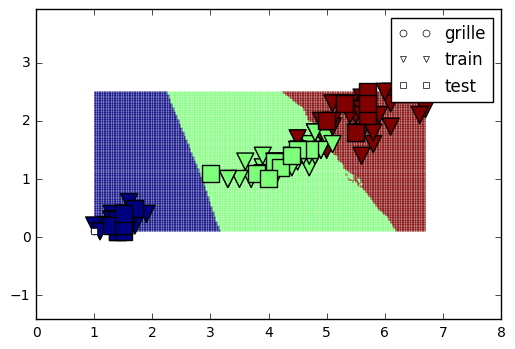

On va sauvegarder la figure dans  grille__k=10_c1=0_c2=1.png


In [15]:
train_set, valid_set, test_set, best_model, best_k = experience(n_train=100,n_valid=25,train_cols=[2,3],ks=xrange(1,100))
print "le meilleur k est ",best_k
graphiques(train_set, valid_set, test_set, best_model)

- Décommentez la ligne `random.seed(3395)` et roulez votre code plusieurs fois pour obtenir des statistiques sur les erreurs de validation et de test. Vous pouvez écrire une boucle `for` qui exécute le même code plusieurs fois; 10 fois devrait suffire. Calculez l'écart-type et la moyenne de chaque erreur.

In [11]:
N = 10
results = np.zeros(N)
# on test N fois le modèle sur les même ensemble
for i in range(N):
    train_set, valid_set, test_set, best_model, best_k = experience(n_train=100,n_valid=25,train_cols=[0,1],ks=[7],seed=False)
    
    test_inputs = test_set[:,:-1]
    test_labels = test_set[:,-1].astype('int32')
    
    les_comptes = model.compute_predictions(test_inputs)
    test_pred = np.argmax(les_comptes,axis=1)+1    
    
    # Erreur de test
    results[i] = 100.*(1.0 - (test_labels==test_pred)).mean()

# l'écart-type est considérable étant donné la moyenne d'erreur
# on voit que le seed est important pour la reproductibilité des expériences
print results
print "Moyenne", results.mean()
print "Écart-type", results.std()

[ 12.  36.  16.  16.  20.  20.  16.  24.  36.  32.]
Moyenne 22.8
Écart-type 8.4
